In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Funnynet

## A neural network that makes jokes

Special thanks to taivop for providing the [dataset](https://github.com/taivop/joke-dataset).

This notebook is heavily inspired by [fastai NLP work](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb).

In [2]:
import pdb
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math, random

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

PATH=Path('data')

In [4]:
files = list(PATH.iterdir())
print(files)

[PosixPath('data/val'), PosixPath('data/.ipynb_checkpoints'), PosixPath('data/trn'), PosixPath('data/stupidstuff.json'), PosixPath('data/models'), PosixPath('data/reddit_jokes.json')]


In [5]:
for fname in files:
    if "eddit" in str(fname):
        reddit_dataset = str(fname)
    if "upid" in str(fname):
        stupid_dataset = str(fname)
reddit_jokes = json.load(open(reddit_dataset))
stupid_jokes = json.load(open(stupid_dataset))

In [6]:
len(reddit_jokes)

194553

In [7]:
reddit_jokes[0]

{'body': 'Now I have to say "Leroy can you please paint the fence?"',
 'id': '5tz52q',
 'score': 1,
 'title': 'I hate how you cant even say black paint anymore'}

Let's discard all the jokes that have 0 score, as they aren't that helpful for training

In [8]:
rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

In [9]:
len(rated_jokes)

132992

In [10]:
scores = [joke['score'] for joke in rated_jokes]
np.mean(scores),np.max(scores)

(172.94791416025024, 48526)

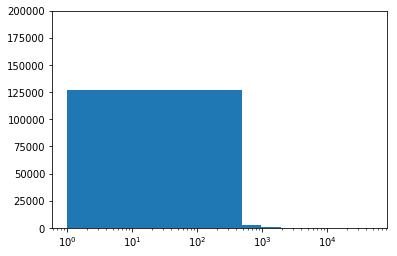

In [11]:
low_scores = [score for score in scores]
plt.xscale('log', nonposx='clip')
plt.ylim(ymax=200000)
#plt.axes.set_ylim([0,200000])
plt.hist(low_scores, bins=100);

In [12]:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]
title_body[0]

'I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"'

Horrible, but formatted correctly. Now, let's combine all the jokes into one long string, using the `EOJ` tag.

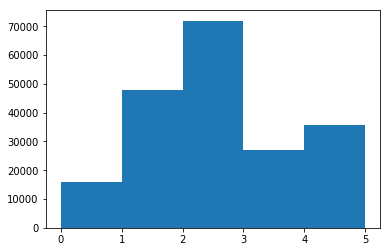

In [13]:
all_jokes = []
for i in range(len(reddit_jokes)):
    r_joke = reddit_jokes[i]
    r_joke['rating']=round(math.log(r_joke['score']+random.randrange(1,10))/math.log(10)*5/2, 2)
    if r_joke['rating']>5: # TODO: use max() here
        r_joke['rating']=5
    del r_joke['score'] 
    r_joke['body'] = r_joke['title']+" "+r_joke['body']
    del r_joke['title']
for s_joke in stupid_jokes:
    del s_joke['category']

combined = [joke['rating'] for joke in reddit_jokes]
combined = combined + [joke['rating'] for joke in stupid_jokes]
plt.hist(combined,bins=5);

combined_jokes = reddit_jokes + stupid_jokes

title_body = [joke['body']+' ' for joke in combined_jokes]

In [14]:
text = ''
for joke in title_body:
    text = text + ' ' + joke + ' ' + EOJ + ' '
    if len(text) > 2700000: 
        break

In [15]:
len(text)
print(text[1000:1100])

ls ‘Jesus Christ, are you still in there?'”  xeoj  You hear about the University book store worker w


In [16]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)
chars.insert(0, "\0")
print(chars)

total chars: 160
['\x00', '\t', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}', '~', '\x9d', '\xa0', '¡', '¢', '£', '«', '°', '´', '»', 'Ñ', '×', 'à', 'ä', 'è', 'é', 'ì', 'í', 'ñ', 'ó', 'ʖ', '͜', '͡', 'μ', 'π', '\u2009', '\u200b', '\u200f', '–', '—', '‘', '’', '“', '”', '•', '…', '\u2028', '″', '‽', '€', '√', '∫', '☝', '♻', '主', '人', '斋', '林', '浮', '白', '笑', '\ufeff', '🇩', '🇰', '😁', '😂', '😇', '😈', '😊', '😋', '😎', '😨', '🤣']


It appears there are Emojis in the dataset. 

In [17]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

In [18]:
idx = [char_indices[c] for c in text]

idx[:10]

[4, 45, 4, 76, 69, 88, 73, 4, 76, 83]

In [19]:
''.join(indices_char[i] for i in idx[:70])

' I hate how you cant even say black paint anymore Now I have to say "L'

Partitioning the dataset and writing it to /data/trn/trn.txt and /data/val/val.txt

In [20]:
PATH='data/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH} # Don't do this, use pathlib(), it's a lot cleaner

models/  reddit_jokes.json  stupidstuff.json  trn/  val/


In [21]:
trn = open(TRN+"trn.txt","wb")
#rn.write("test")
trn.write(text[0:int(len(text)*4/5)].encode('utf-8'))#str(idx[0:int(len(idx)*2/3)]))
trn.close()
val = open(VAL+"val.txt","wb")
#al.write("test")
val.write(text[int(len(text)*4/5):len(text)-1].encode('utf-8'))#str(idx[int(len(idx)*2/3):len(idx)-1]))
val.close()

## Three character model

In [22]:
len(idx)

2700100

In [23]:
cs = 3
c1_data = c2_data = c3_data = c4_data = []
for i in range(0, len(idx)-cs, cs):
    c1_data.append(idx[i])
    c2_data.append(idx[i+1])
    c3_data.append(idx[i+2])
    c4_data.append(idx[i+3])

### Create the input and outputs of our RNN

In [24]:
x1 = np.stack(c1_data)
x2 = np.stack(c2_data)
x3 = np.stack(c3_data)
y  = np.stack(c4_data)

### Create and train model

In [25]:
n_hidden = 256
embeddings_sz = 42 #size of embeddings matrix

In [26]:
# These libraries require some setup, try the pip install git+https.github.com/... trick
from fastai.io import *
from fastai.conv_learner import *

from fastai.column_data import *

In [27]:
class ThreeCharRNN(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1))) # Why relu?
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        h = V(torch.zeros(in1.size()).cuda())
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h))

In [28]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512)

In [29]:
model = ThreeCharRNN(vocab_size, embeddings_sz).cuda()

In [30]:
train_iterator = iter(md.trn_dl)
*xs,yt = next(train_iterator)
t = model(*V(xs))

In [31]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [32]:
fit(model, md, epochs=1, opt=optimizer, crit=F.nll_loss) # The negative log likelihood loss

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.003494   0.0       



[0.0]

In [33]:
set_lrs(optimizer, 0.001)

In [34]:
fit(model, md, 1, optimizer, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.000194   0.0       



[0.0]

In [35]:
# TODO: what is going on with the indentation here? Use 4 spaces, not 3

# def get_next(input):
#     running_indicies = [] # Use get_next_n() here
#     indicies = []
#     for char in input:
#         running_indicies.append(char_indices[char])
#     for i in range(10):
#         indicies = np.array(running_indicies[-3:])
#         indicies = T(indicies)
#        prediction = model(*VV(indicies))
#        pred_idx = np.argmax(to_np(prediction))
#        running_indicies.append(pred_idx)
#    result_chars = []
#    for index in running_indicies:
#        result_chars.append(chars[index])
#    return result_chars


def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = model(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [36]:
get_next('y. ')

' '

In [37]:
get_next('the')

'e'

In [38]:
get_next('blo')

'o'

### Let's create a bigger RNN!

In [39]:
rnn_len=8

In [40]:
# char_in_jokes = [[idx[i+j] for i in range(rnn_len)] for j in range(len(idx)-rnn_len)]
# The above line and the below for loops are the same, just refactored to be easier to read

char_input = []
for j in range(len(idx)-rnn_len):
    tmp = []
    for i in range(rnn_len):
        tmp.append(idx[i+j])
    char_input.append(tmp)

In [41]:
char_output = []
for j in range(len(idx)-rnn_len):
    char_output.append(idx[j+rnn_len])

In [42]:
xs = np.stack(char_input, axis=0)

In [43]:
xs.shape

(2700092, 8)

In [44]:
y = np.stack(char_output)
y.shape

(2700092,)

In [45]:
xs[:rnn_len,:rnn_len]

array([[ 4, 45,  4, 76, 69, 88, 73,  4],
       [45,  4, 76, 69, 88, 73,  4, 76],
       [ 4, 76, 69, 88, 73,  4, 76, 83],
       [76, 69, 88, 73,  4, 76, 83, 91],
       [69, 88, 73,  4, 76, 83, 91,  4],
       [88, 73,  4, 76, 83, 91,  4, 93],
       [73,  4, 76, 83, 91,  4, 93, 83],
       [ 4, 76, 83, 91,  4, 93, 83, 89]])

In [46]:
len(y[:rnn_len])

8

In [47]:
val_idx = get_cv_idxs(len(idx)-rnn_len-1)
# val_idx.shape

In [48]:
model_data = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [49]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
#         pdb.set_trace()
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
            
        return F.log_softmax(self.l_out(h), dim=-1)

In [50]:
model = CharLoopModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(model.parameters(), 1e-2)

In [51]:
fit(model, model_data, epochs=1, opt=opt, crit=F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      2.075454   2.111557  



[2.111557]

In [52]:
set_lrs(opt, 0.001)

In [53]:
fit(model, model_data, epochs=1, opt=opt, crit=F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      1.778078   1.789337  



[1.7893368]

In [54]:
get_next('for thos')

'e'

In [55]:
get_next(' a blond')

'e'

In [56]:
get_next('into a b')

'e'

In [57]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [58]:
get_next_n('into a b', 40)

'into a be the be the be the be the be the be the'

In [59]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz+n_hidden, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = torch.cat((h, self.e(c)), 1)
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [60]:
m = CharLoopConcatModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [61]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [62]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.00011    2e-06     



[1.9073486e-06]

In [63]:
set_lrs(opt, 1e-4)

In [64]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      7e-06      0.0       



[0.0]

### Test model

In [65]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [66]:
get_next('wome')

'w'

In [67]:
get_next('beca')

'b'

In [68]:
get_next('char')

'c'

### RNN with pytorch

### Model with Multiple Outputs

In [69]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        #print("rnn_len: "+str(rnn_len))
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

In [70]:
m = CharRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [71]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [72]:
t = m.e(V(torch.stack(xs)))
t.size()

torch.Size([3, 512, 42])

In [73]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

(torch.Size([3, 512, 256]), torch.Size([1, 512, 256]))

In [74]:
t = m(*V(xs)); t.size()

torch.Size([512, 160])

In [75]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      1.8e-05    2e-06     
    1      0.000178   0.0                                         
    2      0.0        0.0                                         
    3      3.4e-05    0.0                                         



[0.0]

In [76]:
set_lrs(opt, 1e-4)

In [77]:
fit(m, md, 2, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                    
    0      0.0        0.0       
    1      0.0        0.0                                         



[0.0]

### Test model

In [78]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [79]:
get_next('for thos')

'o'

In [80]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [81]:
get_next_n('for thos', 40)

'for thosoooooooooooooooooooooooooooooooooooooooo'

## Multi output model

### Setup

Let's take non-overallping sets of characters this time

In [82]:
c_in_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(0, len(idx)-rnn_len-1, rnn_len)]

In [83]:
c_out_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(1, len(idx)-rnn_len, rnn_len)]

In [84]:
xs = np.stack(c_in_dat)
xs.shape

(337512, 8)

In [85]:
xs[:rnn_len,:rnn_len]

array([[ 4, 45,  4, 76, 69, 88, 73,  4],
       [76, 83, 91,  4, 93, 83, 89,  4],
       [71, 69, 82, 88,  4, 73, 90, 73],
       [82,  4, 87, 69, 93,  4, 70, 80],
       [69, 71, 79,  4, 84, 69, 77, 82],
       [88,  4, 69, 82, 93, 81, 83, 86],
       [73,  4, 50, 83, 91,  4, 45,  4],
       [76, 69, 90, 73,  4, 88, 83,  4]])

In [86]:
ys = np.stack(c_out_dat)
ys.shape

(337512, 8)

In [87]:
ys[:rnn_len,:rnn_len]

array([[45,  4, 76, 69, 88, 73,  4, 76],
       [83, 91,  4, 93, 83, 89,  4, 71],
       [69, 82, 88,  4, 73, 90, 73, 82],
       [ 4, 87, 69, 93,  4, 70, 80, 69],
       [71, 79,  4, 84, 69, 77, 82, 88],
       [ 4, 69, 82, 93, 81, 83, 86, 73],
       [ 4, 50, 83, 91,  4, 45,  4, 76],
       [69, 90, 73,  4, 88, 83,  4, 87]])

### Create and train model

In [88]:
val_idx = get_cv_idxs(len(xs)-rnn_len-1)

In [89]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [90]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp), dim=-1)

In [91]:
m = CharSeqRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [92]:
it = iter(md.trn_dl)
*xst,yt = next(it)
#t = m(*V(xs))

In [93]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [94]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.084811   2.060115  
    1      1.935882   1.92809                               
    2      1.870535   1.871492                              
    3      1.83798    1.838083                              



[1.8380834]

In [95]:
set_lrs(opt, 1e-4)

In [96]:
fit(m, md, 1, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.811239   1.82215   



[1.82215]

## Identity init!

In [97]:
m = CharSeqRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [98]:
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))


    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      1     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 256x256 (GPU 0)]

In [99]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.005716   1.98064   
    1      1.945557   1.942255                              
    2      1.912102   1.9171                                
    3      1.900668   1.903607                              



[1.9036067]

In [ ]:
set_lrs(opt, 1e-3)

In [ ]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.823887   1.830701  
 17%|█▋        | 88/528 [00:02<00:14, 31.03it/s, loss=1.82]

## Stateful model

### Adding State: RNN

### Setup

In [ ]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

In [ ]:
PATH='data/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

Looks like this next part assumes we have already partitioned the data into trn/trn.txt and val/val.txt for training and validation sets, respectively.

In [ ]:
TEXT = data.Field(lower=True, tokenize=list)
print("TEXT: "+str(TEXT))
bs=64; bptt=8; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

In [ ]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [ ]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
fit(m, md, 4, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

fit(m, md, 4, opt, F.nll_loss)

### LSTM
Now we will try an LSTM

In [ ]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *
from fastai import sgdr
n_hidden = 256

In [ ]:
# val_idx = get_cv_idxs(len(xs)-rnn_len-1)
# print(val_idx)

In [ ]:
# print(xs)
# print(ys)
# md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)
# print(md)

In [ ]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, embeddings_sz, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.LSTM(embeddings_sz, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, rnn_len):
        bs = rnn_len[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(rnn_len), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [ ]:
m = CharSeqStatefulLSTM(len(chars)+1,embeddings_sz, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [ ]:
fit(m, md, 2, lo.opt, F.nll_loss)

## He trains for 2^6 epochs... I'm not waiting that long

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

### Test

In [ ]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [ ]:
get_next('into a b')

In [ ]:
get_next('a ma')

In [ ]:
get_next('blon')

In [ ]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
print(get_next_n('into a b', 400))

In [ ]:
print(get_next_n('blon', 200))

In [ ]:
print(get_next_n('what do y',400))

In [ ]:
def get_next_n_jokes(prompt,n):
    jokes = []
    c = ''
    for j in range(n):
        inp = prompt
        res = prompt
        while res[-5:-1]!="xeoj":
            c = get_next(inp)
            res += c
            inp = inp[1:]+c
        jokes.append(res)
    return jokes

In [ ]:
for joke in get_next_n_jokes('the blon',4):
    print(joke)
    print("\n")

In [ ]:
for joke in get_next_n_jokes('he smashes the bir',4):
    print(joke)
    print("\n")

In [ ]:
for joke in get_next_n_jokes('what do you get wh',4):
    print(joke)
    print("\n")

In [ ]:
for joke in get_next_n_jokes('a sunday school teacher',4):
    print(joke)
    print("\n")

In [ ]:
for joke in get_next_n_jokes('why women need legs',4):
    print(joke)
    print("\n")

In [ ]:
for joke in get_next_n_jokes("i hate how you can't s",4):
    print(joke)
    print("\n")

In [ ]:
for joke in get_next_n_jokes("you hear about the university book store worker",4):
    print(joke)
    print("\n")